# PyMC3

Probabilistic Programming in Python: Bayesian Modeling and Probabilistic Machine Learning with Theano

See also: https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers

In [1]:
%matplotlib inline
import numpy as np
import theano.tensor as tt
import pymc3 as pm

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context('notebook')

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Model creation

Models in PyMC3 are centered around the Model class. It has references to all random variables (RVs) and computes the model logp and its gradients. Usually, you would instantiate it as part of a with context:

In [2]:
with pm.Model() as model:
    mu = pm.Normal('mu', mu=0, sd=1)
    obs = pm.Normal('obs', mu=mu, sd=1, observed=np.random.randn(100))

In [3]:
model.basic_RVs

[mu, obs]

In [4]:
model.free_RVs

[mu]

In [5]:
model.observed_RVs

[obs]

In [6]:
model.logp({'mu': 0})

array(-150.04775092632516)

## Probabilistic distributions

Every probabilistic program consists of observed and unobserved Random Variables (RVs). Observed RVs are defined via likelihood distributions, while unobserved RVs are defined via prior distributions.

### Deterministic transforms

PyMC3 allows you to freely do algebra with RVs in all kinds of ways:

In [7]:
with pm.Model():
    x = pm.Normal('x', mu=0, sd=1)
    y = pm.Gamma('y', alpha=1, beta=1)
    plus_2 = x + 2
    summed = x + y
    squared = x**2
    sined = pm.math.sin(x)

While these transformations work seamlessly, its results are not stored automatically. Thus, if you want to keep track of a transformed variable, you have to use pm.Determinstic:

In [8]:
with pm.Model():
    x = pm.Normal('x', mu=0, sd=1)
    plus_2 = pm.Deterministic('x plus 2', x + 2)

Note that plus_2 can be used in the identical way to above, we only tell PyMC3 to keep track of this RV for us.

## Automatic transforms of bounded RVs

In order to sample models more efficiently, PyMC3 automatically transforms bounded RVs to be unbounded.

In [9]:
with pm.Model() as model:
    x = pm.Uniform('x', lower=0, upper=1)

When we look at the RVs of the model, we would expect to find x there, however:

In [10]:
model.free_RVs

[x_interval__]

`x_interval__` represents x transformed to accept parameter values between -inf and +inf. In the case of an upper and a lower bound, a `LogOdds` transform is applied. Sampling in this transformed space makes it easier for the sampler. PyMC3 also keeps track of the non-transformed, bounded parameters. These are common determinstics (see above):

In [11]:
model.deterministics

[x]

When displaying results, PyMC3 will usually hide transformed parameters. You can pass the include_transformed=True parameter to many functions to see the transformed parameters that are used for sampling.

You can also turn transforms off:

In [12]:
with pm.Model() as model:
    x = pm.Uniform('x', lower=0, upper=1, transform=None)

model.free_RVs

[x]

## Lists of RVs / higher-dimensional RVs

Above we have seen how to create scalar RVs. In many models, you want multiple RVs.

In [13]:
with pm.Model() as model:
    x = pm.Normal('x', mu=0, sd=1, shape=10)

`x` is now a random vector of length 10. We can index into it or do linear algebra operations on it:

In [14]:
with model:
    y = x[0] * x[1] # full indexing is supported
    x.dot(x.T) # Linear algebra is supported


## Initialization with test_values

While PyMC3 tries to automatically initialize models it is sometimes helpful to define initial values for RVs. This can be done via the testval kwarg:

In [15]:
with pm.Model():
    x = pm.Normal('x', mu=0, sd=1, shape=5)

x.tag.test_value

array([ 0.,  0.,  0.,  0.,  0.])

In [16]:
with pm.Model():
    x = pm.Normal('x', mu=0, sd=1, shape=5, testval=np.random.randn(5))

x.tag.test_value

array([ 0.10643005, -2.12406298, -2.4482307 ,  1.78417809, -0.96262141])

This technique is quite useful to identify problems with model specification or initialization.

## Inference

Once we have defined our model, we have to perform inference to approximate the posterior distribution. PyMC3 supports two broad classes of inference: sampling and variational inference.

### Sampling

The main entry point to MCMC sampling algorithms is via the pm.sample() function. By default, this function tries to auto-assign the right sampler(s) and auto-initialize if you don’t pass anything.

In [29]:
with pm.Model() as model:
    mu = pm.Normal('mu', mu=0, sd=1)
    sd = pm.HalfNormal('sd', sd=1)
    obs = pm.Normal('obs', mu=mu, sd=sd, observed=np.random.randn(100))

    trace = pm.sample(1000, tune=500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd_log__, mu]
100%|██████████| 1500/1500 [00:01<00:00, 1023.41it/s]


As you can see, on a continuous model, PyMC3 assigns the NUTS sampler, which is very efficient even for complex models. PyMC3 also runs variational inference (i.e. ADVI) to find good starting parameters for the sampler. Here we draw 1000 samples from the posterior and allow the sampler to adjust its parameters in an additional 500 iterations. These 500 samples are discarded by default:

In [30]:
len(trace)

1000

In [31]:
trace['mu'].shape

(2000,)

In [32]:
trace.nchains

2

In [33]:
trace.get_values('mu', chains=1).shape # get values of a single chain

(1000,)

In [34]:
list(filter(lambda x: x[0].isupper(), dir(pm.step_methods)))

['BinaryGibbsMetropolis',
 'BinaryMetropolis',
 'CSG',
 'CategoricalGibbsMetropolis',
 'CauchyProposal',
 'CompoundStep',
 'DEMetropolis',
 'ElemwiseCategorical',
 'EllipticalSlice',
 'HamiltonianMC',
 'LaplaceProposal',
 'Metropolis',
 'MultivariateNormalProposal',
 'NUTS',
 'NormalProposal',
 'PoissonProposal',
 'SGFS',
 'SMC',
 'Slice']

Commonly used step-methods besides NUTS are Metropolis and Slice. For almost all continuous models, ``NUTS`` should be preferred.

### Analyze sampling results

The most common used plot to analyze sampling results is the so-called trace-plot:

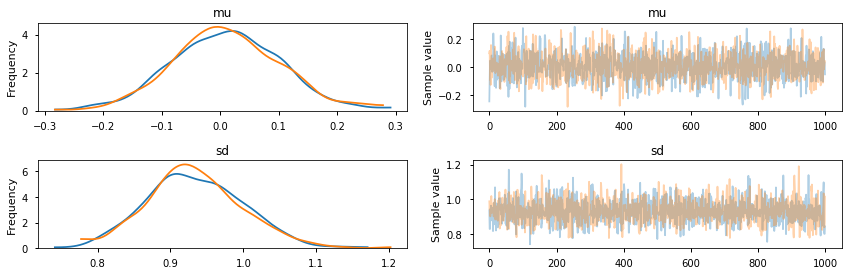

In [35]:
pm.traceplot(trace);

In [38]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu,0.009882,0.092184,0.002156,-0.182517,0.182928,1716.650679,0.999640
sd,0.933104,0.065251,0.001460,0.816496,1.067350,1810.783723,0.999503


Another common metric to look at is R-hat, also known as the Gelman-Rubin statistic:

In [36]:
pm.gelman_rubin(trace)

{'mu': 0.99964011861688995, 'sd': 0.99950294974860177}

These are also part of the forestplot:

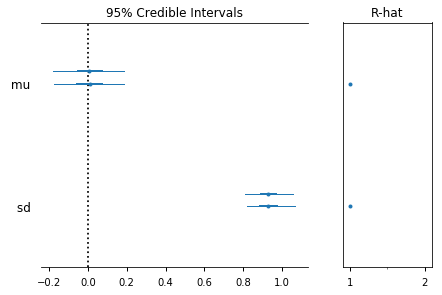

In [39]:
pm.forestplot(trace);

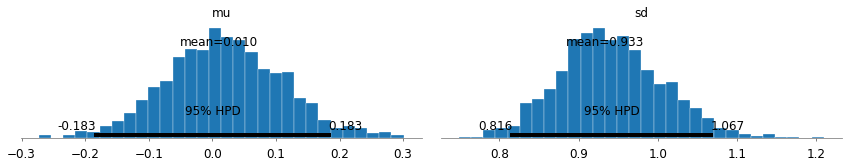

In [40]:
pm.plot_posterior(trace);

For high-dimensional models it becomes cumbersome to look at all parameter’s traces. When using NUTS we can look at the energy plot to assess problems of convergence:

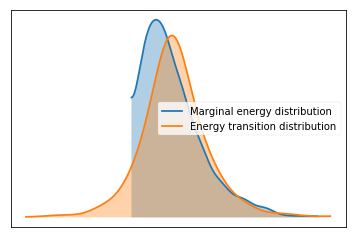

In [41]:
pm.energyplot(trace);

### Variational inference

PyMC3 supports various Variational Inference techniques. While these methods are much faster, they are often also less accurate and can lead to biased inference. The main entry point is `pymc3.fit()`.

In [42]:
with pm.Model() as model:
    mu = pm.Normal('mu', mu=0, sd=1)
    sd = pm.HalfNormal('sd', sd=1)
    obs = pm.Normal('obs', mu=mu, sd=sd, observed=np.random.randn(100))

    approx = pm.fit()

Average Loss = 146.82: 100%|██████████| 10000/10000 [00:07<00:00, 1384.42it/s]
Finished [100%]: Average Loss = 146.81


The returned `Approximation` object has various capabilities, like drawing samples from the approximated posterior, which we can analyse like a regular sampling run:

In [44]:
approx.sample(500)

<MultiTrace: 1 chains, 500 iterations, 3 variables>

### Posterior Predictive Sampling

The `sample_ppc()` function performs prediction on hold-out data and posterior predictive checks.

In [43]:
data = np.random.randn(100)
with pm.Model() as model:
    mu = pm.Normal('mu', mu=0, sd=1)
    sd = pm.HalfNormal('sd', sd=1)
    obs = pm.Normal('obs', mu=mu, sd=sd, observed=data)

    trace = pm.sample()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd_log__, mu]
100%|██████████| 1000/1000 [00:01<00:00, 950.05it/s]


In [45]:
with model:
    post_pred = pm.sample_ppc(trace, samples=500, size=len(data))

100%|██████████| 500/500 [00:00<00:00, 509.90it/s]


`sample_ppc()` returns a dict with a key for every observed node:

In [47]:
post_pred['obs'].shape

(500, 100)

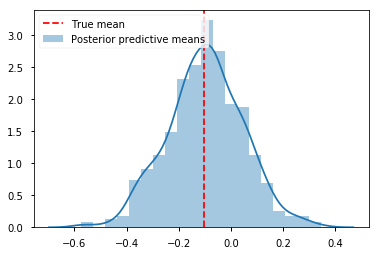

In [48]:
plt.figure()
ax = sns.distplot(post_pred['obs'].mean(axis=1), label='Posterior predictive means')
ax.axvline(data.mean(), color='r', ls='--', label='True mean')
ax.legend()

## Markov Chain Monte Carlo in Python
The PyMC3 documentation might be hard to read. The following is a great example about how PyMC3 can be used to get the posterior probability of the model parameters:

- Medium: https://towardsdatascience.com/markov-chain-monte-carlo-in-python-44f7e609be98
- GitHub notebook: https://github.com/WillKoehrsen/ai-projects/blob/master/markov_chain_monte_carlo/markov_chain_monte_carlo.ipynb

## A Motivating Example: Linear Regression

http://docs.pymc.io/notebooks/getting_started.html

## More examples

http://docs.pymc.io/examples.html